# Support Vector Machine (SVM) for Player Position Prediction

## Overview
This notebook implements Support Vector Machine (SVM) classification to predict player positions based on their statistics.

## To-Do List
1. Import all needed
2. Sanity check data (data playground) + setup dataframe + training/validation sets
3. Perform visualization of data (which may be moved on to another part of the notebook later)
4. Implement three feature transformations 
5. Implement SVM model (hard margin vs soft margin)
6. Include regularization and all those things needed for SVM fixation of over/underfitting 
7. Create a data table of our model (training and validation accuracy)
8. Finish up Conclusion and Analysis

--> For more detail, refer to the Final Project PDF

# 1. Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [7]:
def plot_decision_boundary(clf, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    unique_labels = np.unique(y)
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    y_int = np.array([label_to_int[label] for label in y])
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_int = np.array([label_to_int[label] for label in Z])
    Z_int = Z_int.reshape(xx.shape)
    
    cmap = plt.cm.get_cmap('viridis', len(unique_labels))
    
    plt.contourf(xx, yy, Z_int, alpha=0.8, cmap=cmap)
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y_int, cmap=cmap, edgecolors='k')
    
    cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')


# 2. Data Setup

In [13]:
season_stats = pd.read_csv("players_stats_by_season_with_position.csv")

season_stats = season_stats[season_stats['GP'] > 65]

X = season_stats[[ "GP", "MIN", "FGM", "FGA", "3PM", "3PA", "FTM", "FTA", 
                "TOV", "PF", "ORB", "REB", "AST", "STL", "BLK", "PTS",
                "height_cm", "weight_kg"]]
y = season_stats["position_number"].astype(str) 


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [14]:
#sanity check 

# X_train
# X_test
# y_train
# y_test


# 3. Data Visualization

In [16]:
season_stats_copy = season_stats['position_number'].value_counts()
print(season_stats_copy)


position_number
1    290
3    222
2     96
4     89
5     87
Name: count, dtype: int64


In [17]:
#I don't want to use scaled data for visualization, so I'm using the original data for this
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

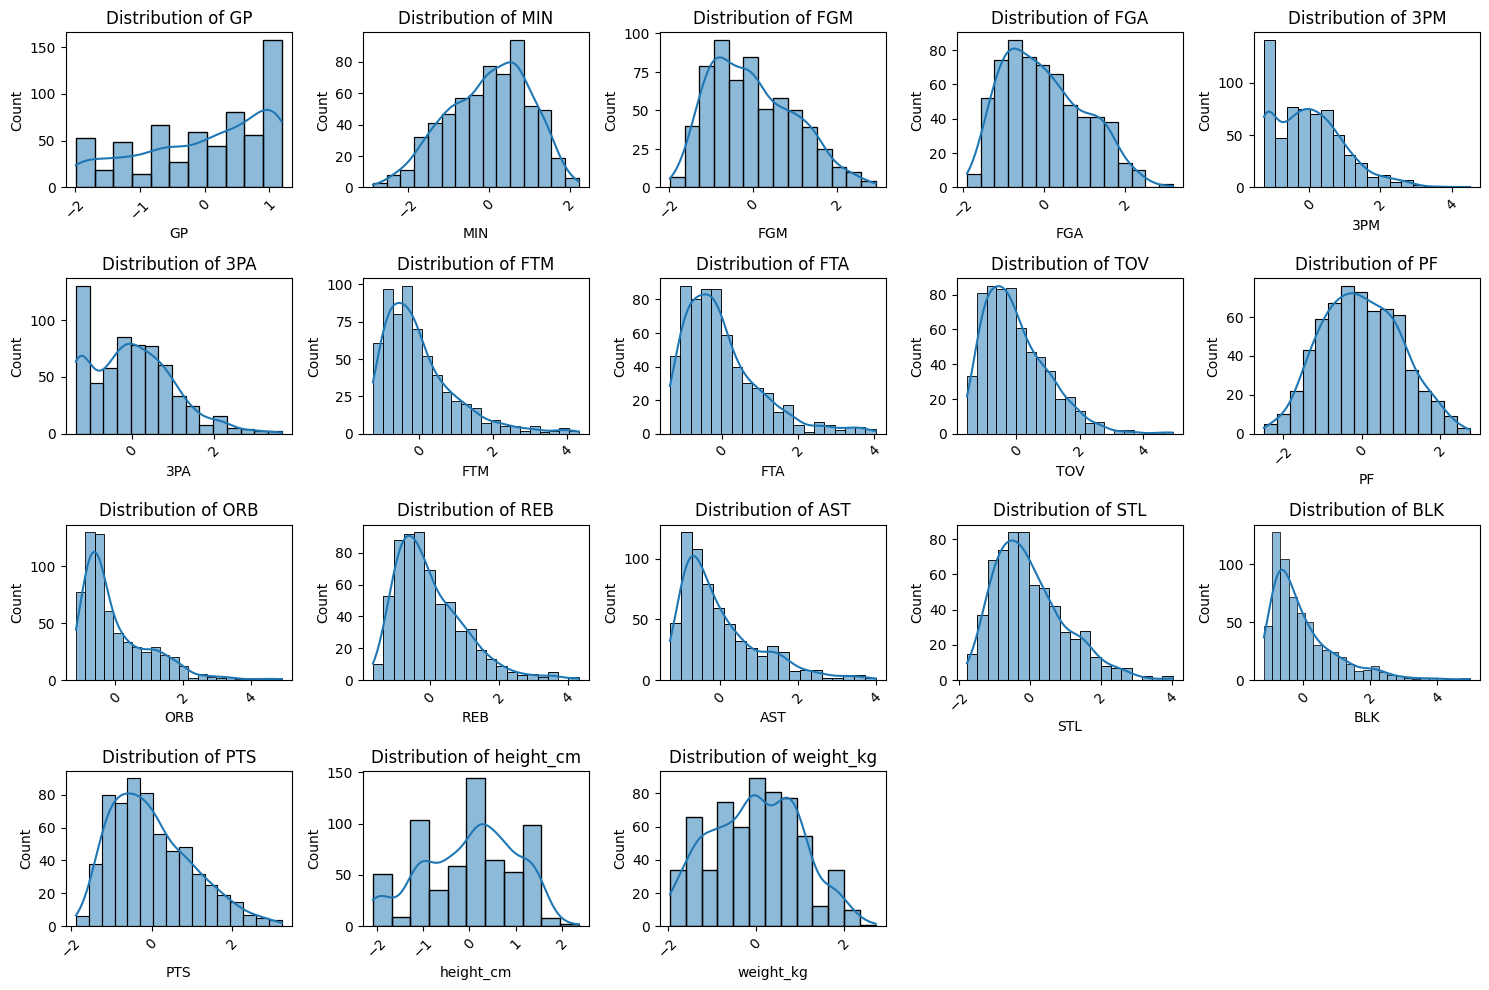

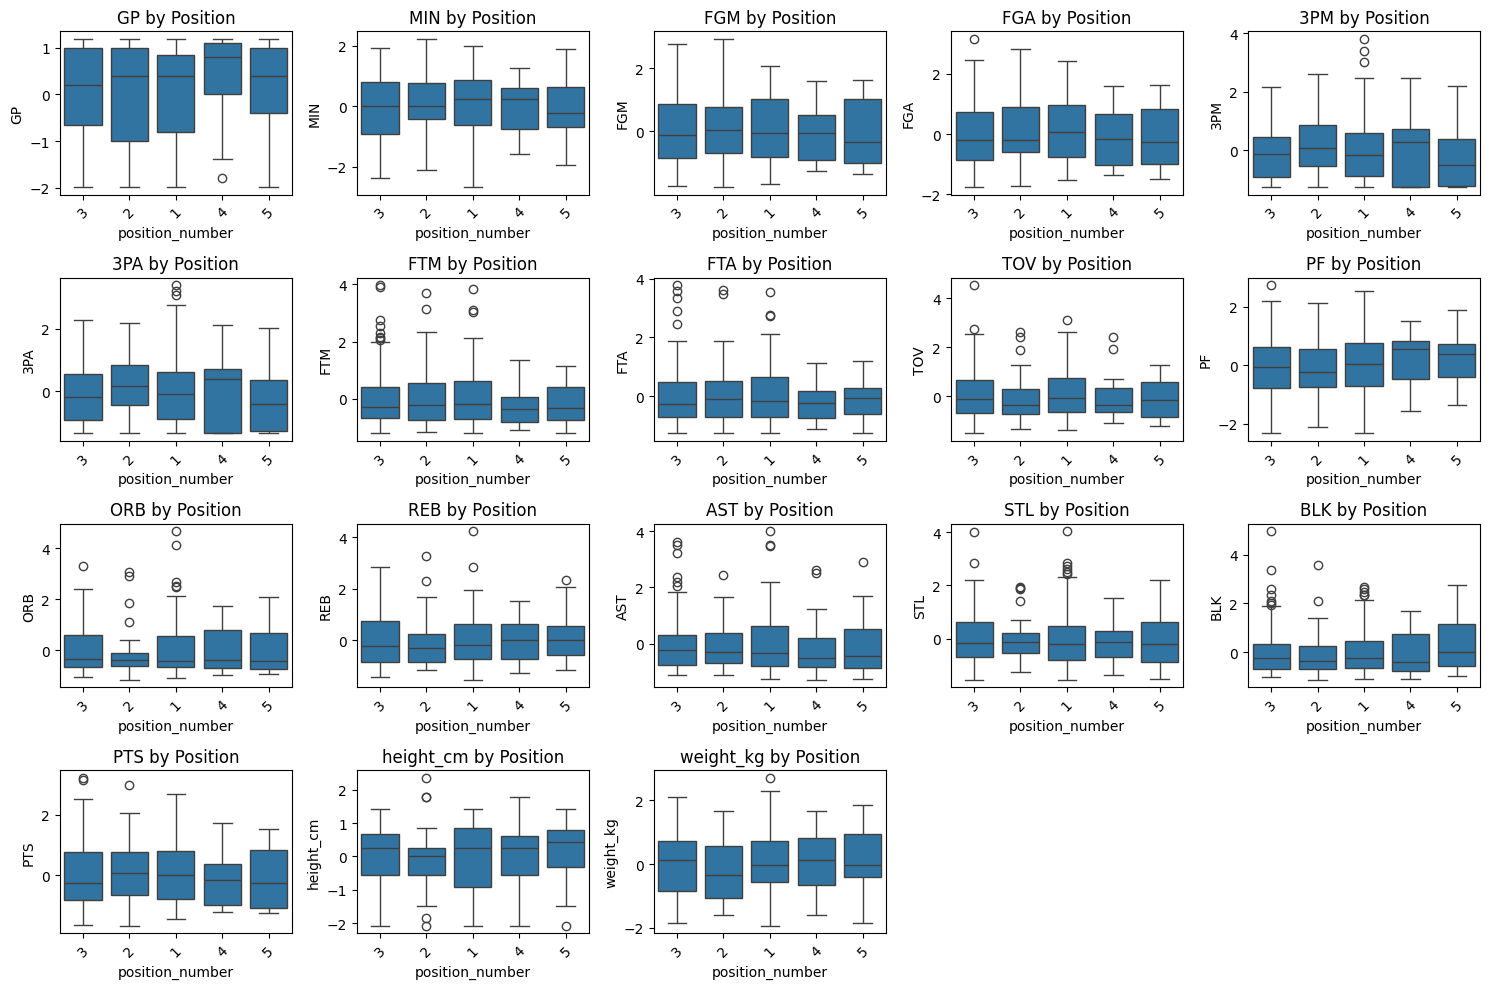

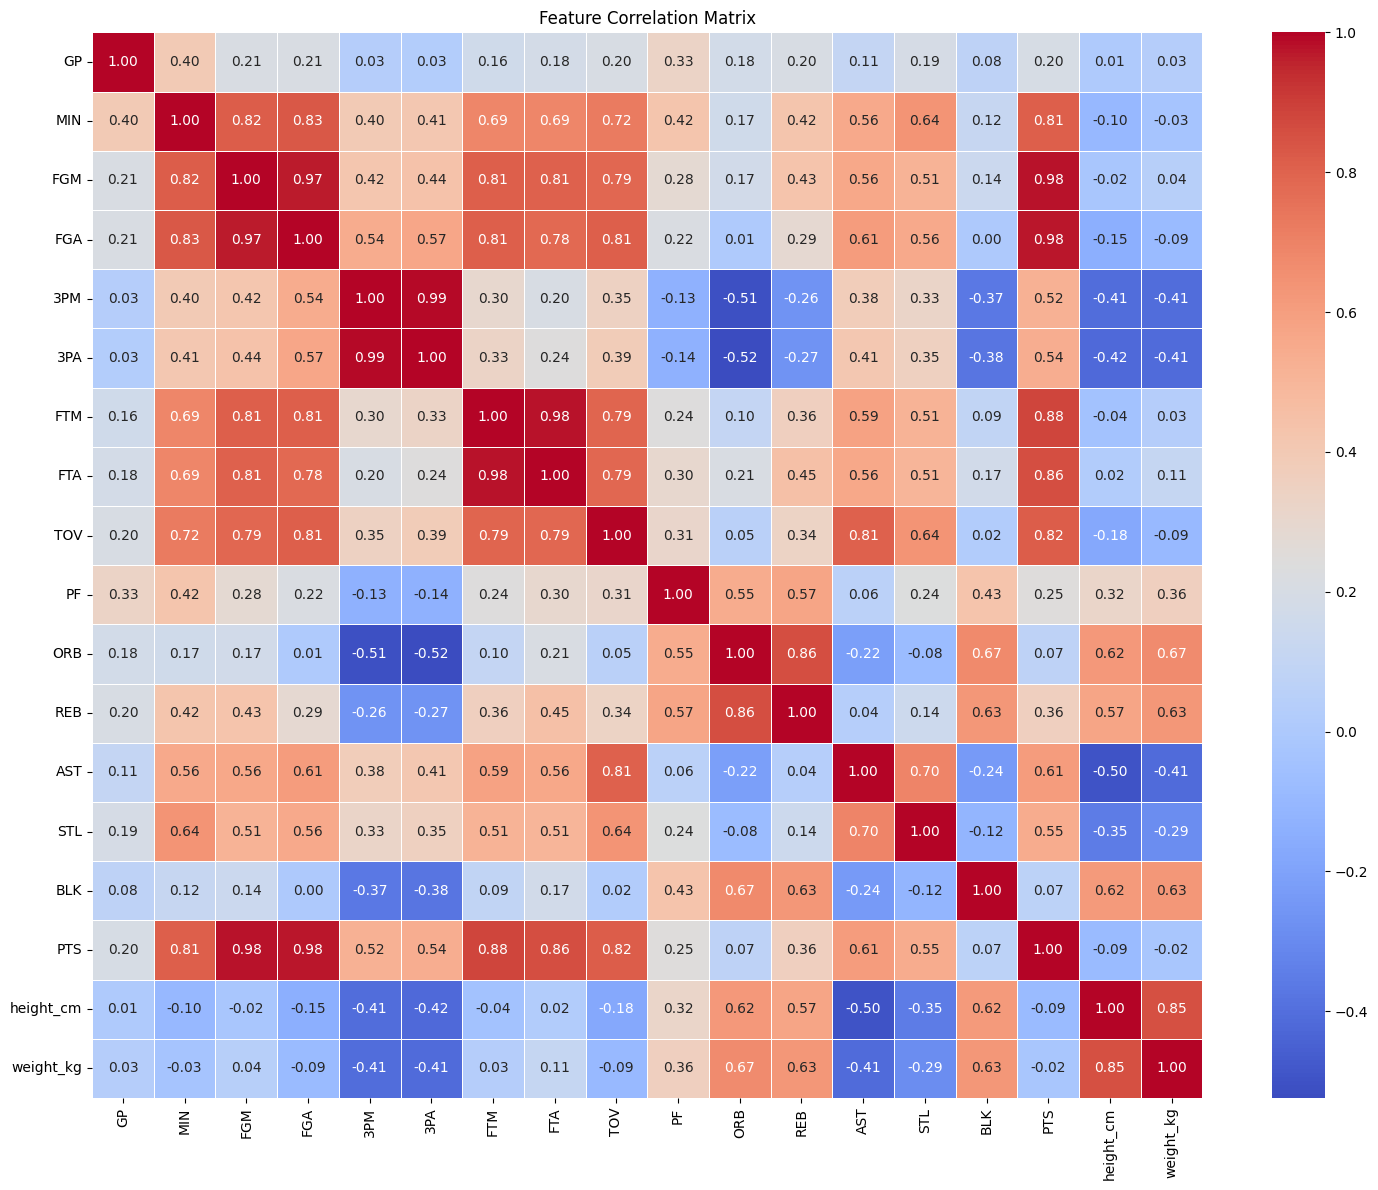

In [18]:
# Convert scaled training data back to DataFrame for visualization
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# 1. Distribution of features
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_train_df.columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(data=X_train_df, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature relationships with target
plt.figure(figsize=(15, 10))
for i, column in enumerate(X_train_df.columns, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(x=y_train, y=X_train_df[column])
    plt.title(f'{column} by Position')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Correlation matrix
plt.figure(figsize=(15, 12))
correlation_matrix = X_train_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 4. Feature Transformation

In [19]:
# 1. Polynomial Features
def apply_polynomial_features(X_train, X_test, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    return X_train_poly, X_test_poly

# 2. RBF Kernel 

# 3. PCA 
def apply_pca(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


# 5. SVM Model 

/Users/epochsum/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/epochsum/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


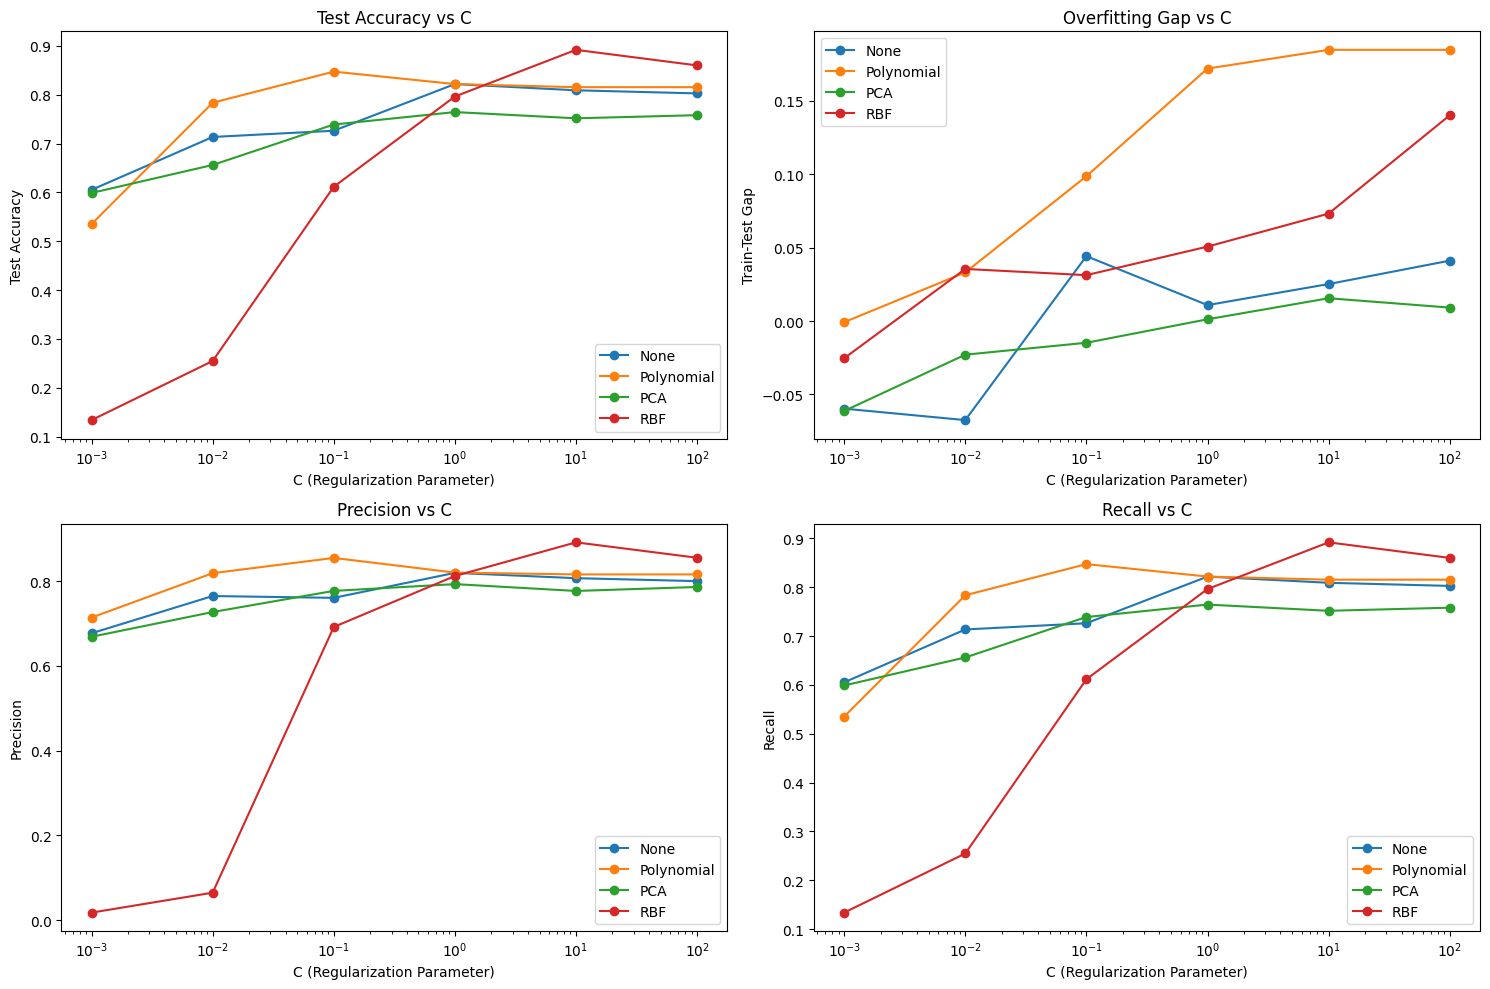

In [20]:
# Define parameters to test
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
transformations = ['None', 'Polynomial', 'PCA', 'RBF']

# Create empty lists to store results
results = []

# 0. No transformation 
for C in C_values:
    # Train model with original features
    model = SVC(kernel='linear', C=C, class_weight='balanced')
    model.fit(X_train, y_train)
    
    # Get training metrics
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Get test metrics
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Get precision, recall for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    # Store results
    results.append({
        'Transformation': 'None',
        'C': C,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Gap': train_acc - test_acc
    })



# 1. Polynomial transformation
for C in C_values:
    # Transform data
    X_train_poly, X_test_poly = apply_polynomial_features(X_train, X_test, degree=2)
    
    # Train model
    model = SVC(kernel='linear', C=C, class_weight='balanced')
    model.fit(X_train_poly, y_train)
    
    # Get training metrics
    y_train_pred = model.predict(X_train_poly)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Get test metrics
    y_test_pred = model.predict(X_test_poly)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Get precision, recall for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    # Store results
    results.append({
        'Transformation': 'Polynomial',
        'C': C,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Gap': train_acc - test_acc
    })

# 2. PCA transformation
for C in C_values:
    # Transform data
    X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, n_components=10)
    
    # Train model
    model = SVC(kernel='linear', C=C, class_weight='balanced')
    model.fit(X_train_pca, y_train)
    
    # Get metrics
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    results.append({
        'Transformation': 'PCA',
        'C': C,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Gap': train_acc - test_acc
    })


# 3. RBF Kernel (original features)
for C in C_values:
    model = SVC(kernel='rbf', C=C, gamma='scale', class_weight='balanced')
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    results.append({
        'Transformation': 'RBF',
        'C': C,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Gap': train_acc - test_acc
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Create visualization
plt.figure(figsize=(15, 10))

# 1. Plot accuracy vs C for each transformation
plt.subplot(2, 2, 1)
for transform in transformations:
    df_trans = results_df[results_df['Transformation'] == transform]
    plt.plot(df_trans['C'], df_trans['Test_Accuracy'], marker='o', label=f'{transform}')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs C')
plt.legend()

# 2. Plot training-test gap
plt.subplot(2, 2, 2)
for transform in transformations:
    df_trans = results_df[results_df['Transformation'] == transform]
    plt.plot(df_trans['C'], df_trans['Gap'], marker='o', label=f'{transform}')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Train-Test Gap')
plt.title('Overfitting Gap vs C')
plt.legend()

# 3. Plot precision
plt.subplot(2, 2, 3)
for transform in transformations:
    df_trans = results_df[results_df['Transformation'] == transform]
    plt.plot(df_trans['C'], df_trans['Precision'], marker='o', label=f'{transform}')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Precision')
plt.title('Precision vs C')
plt.legend()

# 4. Plot recall
plt.subplot(2, 2, 4)
for transform in transformations:
    df_trans = results_df[results_df['Transformation'] == transform]
    plt.plot(df_trans['C'], df_trans['Recall'], marker='o', label=f'{transform}')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Recall')
plt.title('Recall vs C')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
results_df

,Transformation,C,Train_Accuracy,Test_Accuracy,Precision,Recall,F1,Gap
0,None,0.001,0.545455,0.605096,0.677251,0.605096,0.618417,-0.059641
1,None,0.010,0.645933,0.713376,0.765071,0.713376,0.720213,-0.067443
2,None,0.100,0.770335,0.726115,0.760804,0.726115,0.733120,0.044220
3,None,1.000,0.832536,0.821656,0.819733,0.821656,0.818254,0.010880
4,None,10.000,0.834131,0.808917,0.807250,0.808917,0.806241,0.025214
5,None,100.000,0.843700,0.802548,0.800283,0.802548,0.799741,0.041152
6,Polynomial,0.001,0.534290,0.535032,0.714266,0.535032,0.542972,-0.000742
7,Polynomial,0.010,0.816587,0.783439,0.818990,0.783439,0.792716,0.033147
8,Polynomial,0.100,0.945774,0.847134,0.855070,0.847134,0.847674,0.098640
9,Polynomial,1.000,0.993620,0.821656,0.820397,0.821656,0.820713,0.171964


In [22]:
# # PCA transformation 

# X_train_pca, X_test_pca, pca = apply_pca(X_train, X_test, n_components=10)

# # 2. Train SVM
# pca_svm = SVC(kernel='linear', C=0.1, class_weight='balanced')
# pca_svm.fit(X_train_pca, y_train)

# # 3. Visualize first two principal components
# plt.figure(figsize=(10, 7))
# scatter = plt.scatter(
#     X_train_pca[:, 0], X_train_pca[:, 1], 
#     c=y_train.astype(int), cmap='viridis', alpha=0.7, edgecolors='k'
# )
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Player Positions (First Two Principal Components)')
# plt.colorbar(scatter, label='Position')
# plt.show()

# # 4. Print accuracy and classification report
# y_pred_pca = pca_svm.predict(X_test_pca)
# accuracy_pca = accuracy_score(y_test, y_pred_pca)
# print(f"PCA-Transformed SVM Accuracy: {accuracy_pca:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_pca))

# # 5. Print explained variance ratio
# print("\nExplained variance ratio:")
# print(pca.explained_variance_ratio_)

# # Visualization imports
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # 1. Scree Plot
# plt.figure(figsize=(10, 6))
# explained_variance_ratio = pca.explained_variance_ratio_
# plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Scree Plot')
# plt.show()

# # Print the explained variance ratios
# print("Explained variance ratio by component:")
# for i, ratio in enumerate(explained_variance_ratio, 1):
#     print(f"PC{i}: {ratio:.4f}")

# # 2. Cumulative Explained Variance Plot
# plt.figure(figsize=(10, 6))
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Cumulative Explained Variance Plot')
# plt.grid(True)
# plt.show()

# print("\nCumulative explained variance ratio:")
# for i, ratio in enumerate(cumulative_variance_ratio, 1):
#     print(f"First {i} components: {ratio:.4f}")

# # 3. Enhanced Scatter Plot with Decision Boundaries
# def plot_decision_boundary(X, y, model, pca):
#     plt.figure(figsize=(12, 8))
    
#     # Create a mesh grid
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
#                         np.arange(y_min, y_max, 0.1))
    
#     # Make predictions for each point in the mesh
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)
    
#     # Plot the decision boundary
#     plt.contourf(xx, yy, Z, alpha=0.4)
    
#     # Plot the training points
#     scatter = plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
#     plt.colorbar(scatter)
    
#     plt.xlabel('First Principal Component')
#     plt.ylabel('Second Principal Component')
#     plt.title('SVM Decision Boundaries on First Two Principal Components')
#     plt.show()

